# Imports

In [1]:
import os
import re

import emoji
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

pd.set_option('display.max_colwidth', 100)

# Read Data

In [2]:
df_full = pd.read_csv('./data/sampled_data.csv')

In [3]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
        ]]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [4]:
df = pd.concat((X_train, y_train), axis=1)

# Examine Training Data for Cleaning

In [5]:
df.shape

(29630, 24)

In [6]:
df.isna().sum()

id                          0
author                      0
created                     0
retrieved                   0
edited                      0
pinned                      0
archived                    0
locked                      0
removed                     0
deleted                     0
is_self                     0
is_video                    0
is_original_content         0
title                       0
link_flair_text          9974
upvote_ratio                0
gilded                      0
total_awards_received       0
num_comments                0
num_crossposts              0
selftext                    0
thumbnail                   0
shortlink                   0
score                       0
dtype: int64

In [7]:
df.shape

(29630, 24)

In [8]:
df.dropna(subset='score').shape

(29630, 24)

### Dropping Null selftext values

In [9]:
print(df.shape)
df = df.dropna(subset='selftext')
print(df.shape)

(29630, 24)
(29630, 24)


### Filling NA's for link_flair_text

In [10]:
df[df['link_flair_text'].isna()].fillna({'link_flair_text':''}).iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
4939,o9asc4,Trey_Wingo_,2021-06-28 02:10:14,2021-06-28 08:51:56,1970-01-01 00:00:00,0,0,0,0,0,...,,0.67,0,1,6,0,These are the plays I've been eyeing and will watch going forward.\n\nCurrently doing well with ...,https://b.thumbs.redditmedia.com/uD_xWJaejFR3KieWZ2zr7_S67Qsklca4wqv2n6JjM0g.jpg,https://redd.it/o9asc4,2
36719,llykgt,takenorinvalid,2021-02-17 16:37:15,2021-02-18 04:41:31,2021-02-17 16:45:56,0,0,0,0,0,...,,0.92,0,20,491,0,"Things are pretty red today, and a lot of new investors are freaking out right now, so I think i...",self,https://redd.it/llykgt,1000


In [11]:
df.describe()

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
count,29630.0,29630.0,29630.000000,29630.000000,29630.0,29630.0,29630.0,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000,29630.000000
mean,0.0,0.0,0.001451,0.006176,0.0,1.0,0.0,0.018427,0.778928,0.019541,0.797941,66.977320,0.064968,86.707020
std,0.0,0.0,0.038068,0.078347,0.0,0.0,0.0,0.134493,0.198419,0.241056,12.439068,1069.472767,0.524596,1049.409943
min,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.670000,0.000000,0.000000,3.000000,0.000000,1.000000
50%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.820000,0.000000,0.000000,8.000000,0.000000,5.000000
75%,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.950000,0.000000,0.000000,21.000000,0.000000,18.000000
max,0.0,0.0,1.000000,1.000000,0.0,1.0,0.0,1.000000,1.000000,24.000000,1481.000000,75852.000000,30.000000,98013.000000


Remove the "Unnamed: 0" field

In [12]:
df.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink,score
4651,lj513w,FooPeppers,2021-02-13 17:36:33,2021-02-28 17:03:11,1970-01-01 00:00:00,0,0,0,0,0,...,Question,0.98,0,2,64,0,What is it with Robinhood taking so long to give out our tax documents? They’re the only reason ...,self,https://redd.it/lj513w,149
38126,m3r6bf,GodToldMeToPostThis,2021-03-12 21:06:39,2021-03-13 03:18:32,1970-01-01 00:00:00,0,0,0,0,0,...,Question,0.86,0,0,10,0,I’m new to this. Most stocks move up down in a gradual line that curves and what not. I have fou...,self,https://redd.it/m3r6bf,5


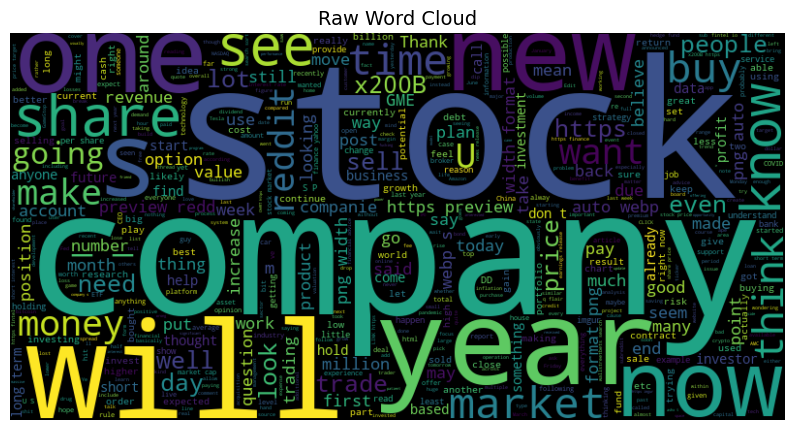

In [13]:
plt.figure(figsize=(10, 10))
words = " ".join(df['selftext'])
wc1 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc1, interpolation='bilinear')
plt.title('Raw Word Cloud', fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

### Reviewing unexpected terms, such as https, webp, pgn.

Where are these words coming from?

In [14]:
search_terms = [r'https', r'webp','png']

The search terms are all part of url's. They will be removed.

In [15]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].iloc[0]

'These are the plays I\'ve been eyeing and will watch going forward.\n\nCurrently doing well with $WISH shares and selling weekly(ish) CC.\n\nI haven\'t played any of the high IV / Meme stocks this year, will start very small -- targets there are from too much research and probably hope from a number of (quality) sources, so again going small. ($PLUG $BB $CLOV $MVIS)\n\nWhat I\'m most interested in:\n\n$GOLD leaps for a double bagger+ before EOY, I see $GOLD making a push again to 1900 before EOY.\n\n$WKHS Shares and Covered Calls for solid gains\n\n$SOFI Shares and some amount of Covered Calls.\n\nIf I\'m stuck bag holding WISH, WKHS, SOFI, I don\'t mind selling CCs for a while above my initial purchase price to eventually get "unstuck".\n\nAnyone like any of these (mostly in the bottom half)?\n\nGLTA!\n\n&#x200B;\n\n[\\*\\*This is my own dumb research and not investment advice\\*\\*](https://preview.redd.it/gfiuwjzjyw771.png?width=1222&format=png&auto=webp&s=414cc4ece12fd6e313aeaff1e

In [16]:
df[df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))]['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).iloc[0]

'These are the plays I\'ve been eyeing and will watch going forward.\n\nCurrently doing well with $WISH shares and selling weekly(ish) CC.\n\nI haven\'t played any of the high IV / Meme stocks this year, will start very small -- targets there are from too much research and probably hope from a number of (quality) sources, so again going small. ($PLUG $BB $CLOV $MVIS)\n\nWhat I\'m most interested in:\n\n$GOLD leaps for a double bagger+ before EOY, I see $GOLD making a push again to 1900 before EOY.\n\n$WKHS Shares and Covered Calls for solid gains\n\n$SOFI Shares and some amount of Covered Calls.\n\nIf I\'m stuck bag holding WISH, WKHS, SOFI, I don\'t mind selling CCs for a while above my initial purchase price to eventually get "unstuck".\n\nAnyone like any of these (mostly in the bottom half)?\n\nGLTA!\n\n&#x200B;\n\n[\\*\\*This is my own dumb research and not investment advice\\*\\*](<url>)'

Remove URL's, and replace with "< url >"

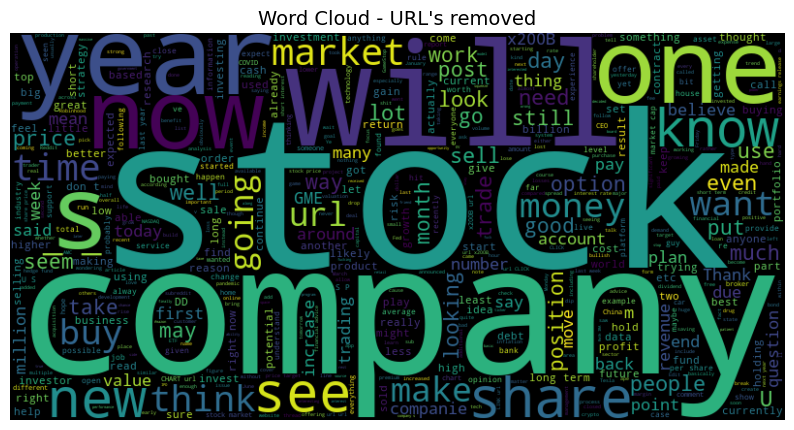

In [17]:
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's removed", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

In [18]:
# Identifying x200b, which is zero width space
search_terms = ['x200']
zero_width_indexes = df['selftext'].apply(lambda x: any(pattern in x for pattern in search_terms))
df[zero_width_indexes]['selftext'].iloc[0][:1000]

'These are the plays I\'ve been eyeing and will watch going forward.\n\nCurrently doing well with $WISH shares and selling weekly(ish) CC.\n\nI haven\'t played any of the high IV / Meme stocks this year, will start very small -- targets there are from too much research and probably hope from a number of (quality) sources, so again going small. ($PLUG $BB $CLOV $MVIS)\n\nWhat I\'m most interested in:\n\n$GOLD leaps for a double bagger+ before EOY, I see $GOLD making a push again to 1900 before EOY.\n\n$WKHS Shares and Covered Calls for solid gains\n\n$SOFI Shares and some amount of Covered Calls.\n\nIf I\'m stuck bag holding WISH, WKHS, SOFI, I don\'t mind selling CCs for a while above my initial purchase price to eventually get "unstuck".\n\nAnyone like any of these (mostly in the bottom half)?\n\nGLTA!\n\n&#x200B;\n\n[\\*\\*This is my own dumb research and not investment advice\\*\\*](https://preview.redd.it/gfiuwjzjyw771.png?width=1222&format=png&auto=webp&s=414cc4ece12fd6e313aeaff1e

In [19]:
# Remove zero width spaces (x200B)
df[zero_width_indexes]['selftext'].apply(lambda x: re.sub(r'x200B', '', x)).iloc[0][:1000]

'These are the plays I\'ve been eyeing and will watch going forward.\n\nCurrently doing well with $WISH shares and selling weekly(ish) CC.\n\nI haven\'t played any of the high IV / Meme stocks this year, will start very small -- targets there are from too much research and probably hope from a number of (quality) sources, so again going small. ($PLUG $BB $CLOV $MVIS)\n\nWhat I\'m most interested in:\n\n$GOLD leaps for a double bagger+ before EOY, I see $GOLD making a push again to 1900 before EOY.\n\n$WKHS Shares and Covered Calls for solid gains\n\n$SOFI Shares and some amount of Covered Calls.\n\nIf I\'m stuck bag holding WISH, WKHS, SOFI, I don\'t mind selling CCs for a while above my initial purchase price to eventually get "unstuck".\n\nAnyone like any of these (mostly in the bottom half)?\n\nGLTA!\n\n&#;\n\n[\\*\\*This is my own dumb research and not investment advice\\*\\*](https://preview.redd.it/gfiuwjzjyw771.png?width=1222&format=png&auto=webp&s=414cc4ece12fd6e313aeaff1ec567a

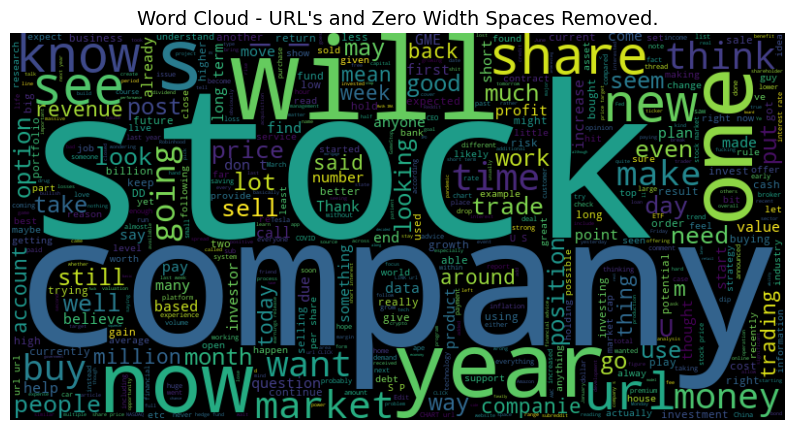

In [20]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'].apply(lambda x: re.sub(r'https?://\S+\b/?', '<url>', x)).apply(lambda x: re.sub(r'x200B', '', x)) )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - URL's and Zero Width Spaces Removed.", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

What are common selftext values, and how should they be handled?

In [21]:
df['selftext'].value_counts().iloc[:5]

selftext
Please  use this thread to have discussions which you don't feel warrant a new  post to the sub. While the Rules for posting questions on the basics of  personal finance/investing topics are relaxed a little bit here, the  rules against memes/spam/self-promotion/excessive rudeness/politics  still apply!\n\nHave a look at the [FAQ](https://www.reddit.com/r/financialindependence/wiki/faq) for this subreddit before posting to see if your question is frequently asked. \n\nSince this post does tend to get busy, consider sorting the comments  by "new" (instead of "best" or "top") to see the newest posts.                                                                                                                                                                                                                                                                                                                                                                                                  

This contains recurring discussion posts and self_text values of '[deleted]' which should be removed.

In [22]:
df.shape, df[df['selftext']!='[deleted]'].shape

((29630, 24), (29630, 24))

### Discussion Posts

Discussion posts will **not be removed** as many users interact with these posts.

In [23]:
text_frequency = df['selftext'].value_counts().reset_index()
text_frequency = text_frequency[text_frequency['count']>3]
discussion_posts = text_frequency['selftext'].tolist()

In [24]:
# Show one discussion post
discussion_posts[0]

'Please  use this thread to have discussions which you don\'t feel warrant a new  post to the sub. While the Rules for posting questions on the basics of  personal finance/investing topics are relaxed a little bit here, the  rules against memes/spam/self-promotion/excessive rudeness/politics  still apply!\n\nHave a look at the [FAQ](https://www.reddit.com/r/financialindependence/wiki/faq) for this subreddit before posting to see if your question is frequently asked. \n\nSince this post does tend to get busy, consider sorting the comments  by "new" (instead of "best" or "top") to see the newest posts.'

# Cleaning Data

### Drop NA's

In [25]:
df = df.dropna(subset='selftext')

### Fill NA's

In [26]:
df = df.fillna({'link_flair_text':''})

### Remove [deleted] selftext entries

In [27]:
df = df[df['selftext']!='[deleted]']

### Preprocess data and clean data
We must remove excess HTML and other words.

In [28]:
unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
df = df.drop(columns=unnamed_columns)

We must remove excess HTML and other words.

In [29]:
def preprocessor(text):
    try:
        text = re.sub('<[^>]*>', '', text)
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                               text)
        text = (re.sub('[\W]+', ' ', text.lower()) +
                ' '.join(emoticons).replace('-', ''))
    except Exception as e:
        print(f'Exception when preprocessing.\n{e}')
    finally:
        return text

# from https://stackoverflow.com/questions/70304914/sentiment-analysis-python-tokenization
def cleaner(text):
    text = str(text).lower()
    text = re.sub(r'#(\w+)', r'<\1>', text)
    text = re.sub(r'\n', ' ', text) # Remove /n
    text = re.sub(r'@[A-Za-z0-9]+', '<user>', text) # Remove and replace @mention
    text = re.sub(r'RT\s+', '', text) # Remove RT
    text = re.sub(r'https?://\S+\b/?', '<url>', text) # Remove and replace links
    text = re.sub('x200B', '', text)
    return text

# There's a chance we WON'T need to convert emojis to text if the model we're using supports emojis, but this might be useful
def deemoji_text(text):
    return emoji_demojize(text)

def deemoji_text_unicode(text):
    return text.encode('unicode-escape').decode('utf-8')

def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+')
    return url_pattern.sub('', text)

def drop_unnamed_columns(df_orig):
    df = df_orig.copy()
    unnamed_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df_full.drop(columns=unnamed_columns)
    return df

In [30]:
df['selftext'] = df['selftext'].apply(cleaner).apply(preprocessor)

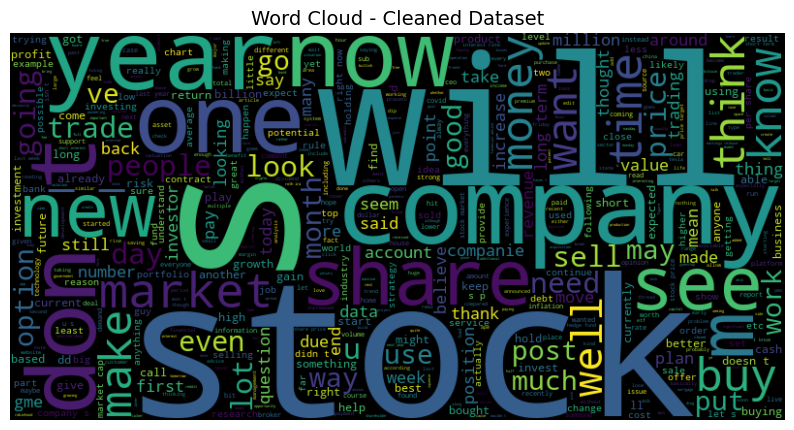

In [31]:
# Replace the HTTPS with <url> and remove zero width spaces (x200B) 
plt.figure(figsize=(10, 10))
words = " ".join( df['selftext'] )
wc2 = WordCloud(max_words=500, width=800, height=400).generate(words)
plt.imshow(wc2, interpolation='bilinear')
plt.title("Word Cloud - Cleaned Dataset", fontsize=14)
plt.axis('off')  # Hide axes
plt.show()

# Standardizing Numeric Fields

### Examine Numeric Fields

In [32]:
numeric_columns = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.values
df[numeric_columns]

,pinned,archived,locked,removed,deleted,is_self,is_video,is_original_content,upvote_ratio,gilded,total_awards_received,num_comments,num_crossposts,score
4651,0,0,0,0,0,1,0,0,0.98,0,2,64,0,149
38126,0,0,0,0,0,1,0,0,0.86,0,0,10,0,5
4939,0,0,0,0,0,1,0,0,0.67,0,1,6,0,2
17828,0,0,0,0,0,1,0,0,0.33,0,0,3,0,0
11510,0,0,0,0,0,1,0,0,0.50,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,0,0,0,0,0,1,0,0,1.00,0,0,5,0,2
39535,0,0,0,0,0,1,0,0,0.93,0,0,0,0,11
41056,0,0,0,0,0,1,0,0,0.71,0,0,5,0,4
30177,0,0,0,0,0,1,0,0,0.66,0,0,7,0,3


### Scale Numeric Fields

In [33]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

In [34]:
scaler = StandardScaler()

df_scaled_values = scaler.fit_transform(df[scaling_fields].values)

df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)

In [35]:
df_std = pd.concat((df[non_scaling_fields].reset_index(drop=True), df_scaled), axis=1)

In [36]:
df_std.iloc[1:3]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,link_flair_text,selftext,thumbnail,shortlink,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts
1,m3r6bf,GodToldMeToPostThis,2021-03-12 21:06:39,2021-03-13 03:18:32,1970-01-01 00:00:00,0,0,0,0,0,...,Question,i m new to this most stocks move up down in a gradual line that curves and what not i have found...,self,https://redd.it/m3r6bf,0.408599,-0.077861,-0.081065,-0.064149,-0.053277,-0.123846
2,o9asc4,Trey_Wingo_,2021-06-28 02:10:14,2021-06-28 08:51:56,1970-01-01 00:00:00,0,0,0,0,0,...,,these are the plays i ve been eyeing and will watch going forward currently doing well with wish...,https://b.thumbs.redditmedia.com/uD_xWJaejFR3KieWZ2zr7_S67Qsklca4wqv2n6JjM0g.jpg,https://redd.it/o9asc4,-0.548989,-0.080720,-0.081065,0.016244,-0.057017,-0.123846


# Full Dataset Cleaning and Training/Validation/Test Assignments

## Decisions:
 * Clean NA's
 * Clean selftext data 
    * brackets
    * URL's
 * Empty rows on the "score" column
 * Dot not remove discussion posts.

In [37]:
df_full = df_full.dropna(subset='selftext')

In [38]:
df_full = df_full.fillna({'link_flair_text':''})

In [39]:
df_full = df_full[df_full['selftext']!='[deleted]']

### Clean and Preprocess Data

In [40]:
df_full['selftext'] = df_full['selftext'].apply(cleaner).apply(preprocessor)

### Drop Columns containing "Unnamed"

In [41]:
df_full = drop_unnamed_columns(df_full)

### Drop Empty selftext

In [42]:
def drop_empty_column_records(df_orig, column):
    df = df_orig.copy()
    return df[df[column]!='']

In [43]:
# df_full = drop_empty_column_records(df_full, 'selftext')

### Scale Numeric Fields

In [44]:
def scale_numeric_fields(scaler, df, df_train, scaling_fields):
    non_scaling_fields = [i for i in df.columns if i not in scaling_fields]

    df_scaled_values = scaler.fit(df_train[scaling_fields].values)
    
    df_scaled_values = scaler.transform(df[scaling_fields].values)
    df_scaled = pd.DataFrame(df_scaled_values, columns=scaling_fields)
    df_scaled = df_scaled.add_suffix('_std', axis=1)

    df_std = pd.concat((df.reset_index(drop=True), df_scaled), axis=1)
    
    return df_std

In [45]:
scaling_fields=['upvote_ratio','score','gilded','total_awards_received','num_comments','num_crossposts']

scaler = StandardScaler()

df_full = scale_numeric_fields(scaler, df_full, df_train, scaling_fields)

In [46]:
df_full.iloc[:2]

,id,author,created,retrieved,edited,pinned,archived,locked,removed,deleted,...,selftext,thumbnail,shortlink,file,upvote_ratio_std,score_std,gilded_std,total_awards_received_std,num_comments_std,num_crossposts_std
0,qjl9qp,aivapes,2021-10-31 08:29:23,2021-10-31 15:51:10,1970-01-01 00:00:00,0,0,0,0,0,...,can t tell you how i know but i actually am 100 certain only posting this here because not many ...,self,https://redd.it/qjl9qp,options/,-2.768083,-0.084450,-0.078968,-0.065282,-0.052455,-0.125439
1,liowew,tomalucian123,2021-02-13 00:27:22,2021-02-13 12:30:48,1970-01-01 00:00:00,0,0,0,0,0,...,i see it everywhere it seems like a good deal by what i have seen they secured a lot of money no...,self,https://redd.it/liowew,pennystocks/,0.608906,-0.076524,-0.078968,-0.065282,-0.060786,-0.125439


# Remove empty selftext records

In [49]:
df_full[df_full['selftext']==''].shape

(65, 31)

In [50]:
df_full = df_full[df_full['selftext']!='']

In [51]:
df_full[df_full['selftext']==''].shape

(0, 31)

### Split Data into Train, Validation, Test sets

In [53]:
def split_data(df_full, split=(0.7, 0.15, 0.15)):
    split = (0.7, 0.15, 0.15) # --> to be discussed with team
    X_full = df_full[['id', 'author', 'created', 'retrieved', 'edited',
           'pinned', 'archived', 'locked', 'removed', 'deleted', 'is_self',
           'is_video', 'is_original_content', 'title', 'link_flair_text',
           'upvote_ratio',  'gilded', 'total_awards_received',
           'num_comments', 'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
           'upvote_ratio_std', 'score_std', 'gilded_std', 'total_awards_received_std',
           'num_comments_std', 'num_crossposts_std']]

    Y_full = df_full['score']

    X_train, X_t, y_train, Y_t = train_test_split(X_full,  Y_full, train_size=split[0], random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_t,  Y_t, train_size=split[1]/(split[1]+split[2]), random_state=1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_full)

In [54]:
X_train.to_csv('./data/final/X_train.csv', index=False)
y_train.to_csv('./data/final/y_train.csv', index=False)
X_val.to_csv('./data/final/X_val.csv', index=False)
y_val.to_csv('./data/final/y_val.csv', index=False)
X_test.to_csv('./data/final/X_test.csv', index=False)
y_test.to_csv('./data/final/y_test.csv', index=False)